In [1]:
import matplotlib.pyplot as plt

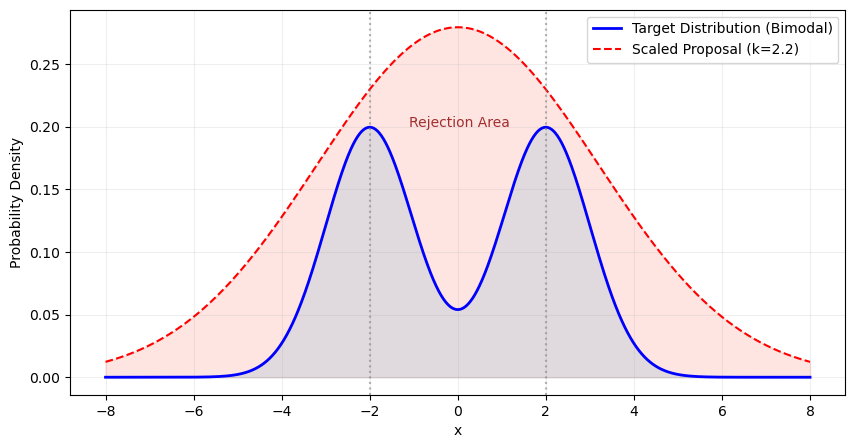

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 定义目标分布（双峰高斯混合模型）
def target_pdf(x):
    return 0.5 * norm.pdf(x, loc=-2, scale=1) + 0.5 * norm.pdf(x, loc=2, scale=1)

# 定义提议分布（单峰高斯）
mu_proposal = 0
sigma_proposal = 3.2  # 调整标准差确保覆盖范围
proposal = lambda x: norm.pdf(x, mu_proposal, sigma_proposal)

# 计算缩放系数k
x_peak = 2  # 已知目标分布在x=±2处有最大值
max_target = target_pdf(x_peak)
max_proposal = proposal(mu_proposal)  # 提议分布峰值
k = max_target / max_proposal * 1.4

# 生成数据点
x = np.linspace(-8, 8, 1000)
target = target_pdf(x)
scaled_proposal = k * proposal(x)

# 可视化
fig = plt.figure(figsize=(10, 5))
plt.plot(x, target, label='Target Distribution (Bimodal)', lw=2, color='blue')
plt.plot(x, scaled_proposal, '--', label=f'Scaled Proposal (k={k:.1f})', color='red')
plt.fill_between(x, target, color='skyblue', alpha=0.3)
plt.fill_between(x, scaled_proposal, color='salmon', alpha=0.2)

# 标注关键区域
plt.axvline(-2, color='gray', linestyle=':', alpha=0.6)
plt.axvline(2, color='gray', linestyle=':', alpha=0.6)
plt.text(-1.1, 0.2, 'Rejection Area', color='darkred', alpha=0.8)

plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

fig.savefig("naive_rej.png")

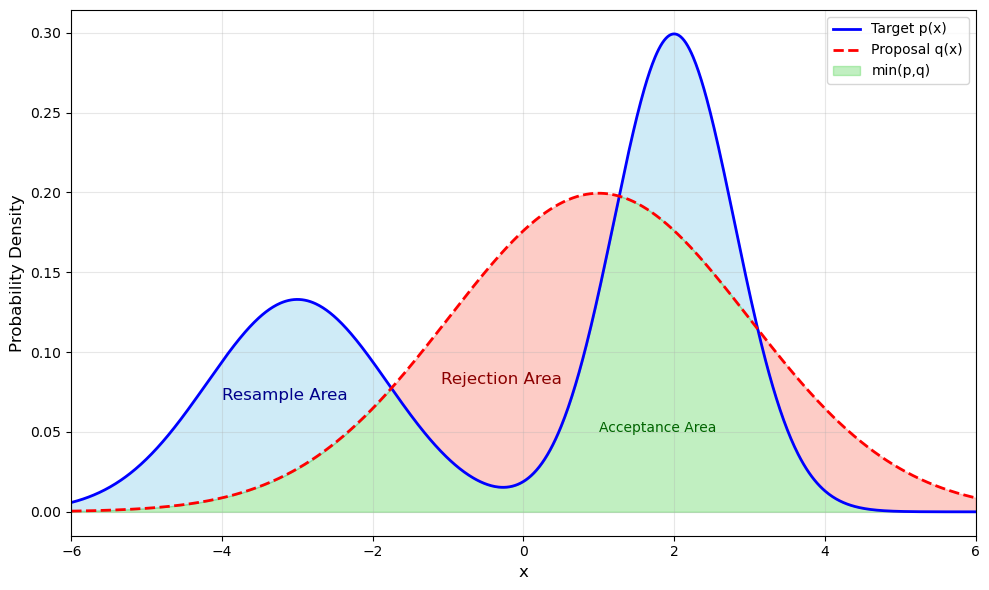

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# 定义目标分布（双峰高斯混合）
def p(x):
    return 0.4*norm.pdf(x, -3, 1.2) + 0.6*norm.pdf(x, 2, 0.8)

# 定义自适应提议分布（示例为分段线性函数）
def q(x):
    return norm.pdf(x, 1, 2)
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], 
    #                    [lambda x: 0.3*np.exp(-0.5*(x+2)**2),
    #                     lambda x: 0.45*np.ones_like(x),
    #                     lambda x: 0.4*np.exp(-0.6*(x-1.5)**2)])

# 寻找交点（数值方法）
def find_intersections():
    intersections = []
    x_test = np.linspace(-6, 6, 1000)
    cross_sign = np.sign(p(x_test) - q(x_test))
  
    for i in range(1, len(x_test)):
        if cross_sign[i] != cross_sign[i-1]:
            sol = root_scalar(lambda x: p(x)-q(x), 
                             bracket=(x_test[i-1], x_test[i]))
            intersections.append(sol.root)
    return np.unique(intersections)

# 计算数据
x = np.linspace(-6, 6, 1000)
p_vals = p(x)
q_vals = q(x)
intersections = find_intersections()

# 创建分段区域标签
regions = np.sort(np.concatenate([[-6], intersections, [6]]))
fill_regions = []

# 可视化设置
fig = plt.figure(figsize=(10,6))
plt.plot(x, p_vals, 'b-', lw=2, label='Target p(x)')
plt.plot(x, q_vals, 'r--', lw=2, label='Proposal q(x)')

# 自动填充不同区域
for i in range(len(regions)-1):
    x_start, x_end = regions[i], regions[i+1]
    mask = (x >= x_start) & (x <= x_end)
    mid_x = (x_start + x_end)/2
    region_type = 'p>q' if p(mid_x) > q(mid_x) else 'q>p'
  
    # 填充区域颜色
    if region_type == 'p>q':
        plt.fill_between(x[mask], p_vals[mask], q_vals[mask], 
                        color='skyblue', alpha=0.4)
    else:
        plt.fill_between(x[mask], q_vals[mask], p_vals[mask],
                        color='salmon', alpha=0.4)

# 绘制min(p,q)区域
plt.fill_between(x, np.minimum(p_vals, q_vals), 
                color='limegreen', alpha=0.3, label='min(p,q)')

# 添加标记和说明
plt.text(-4, 0.07, 'Resample Area', color='darkblue', fontsize=12)
plt.text(-1.1, 0.08, 'Rejection Area', color='darkred', fontsize=12)
plt.text(1, 0.05, 'Acceptance Area', color='darkgreen', fontsize=10)

# 图形装饰
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.xlim(-6,6)
plt.tight_layout()
plt.show()
fig.savefig("adaptive_rej.png")